In [ ]:
!pip3 install hyperopt
!pip3 install eli5
!pip install category_encoders
!pip3 install xgboost==1.7.2
!pip3 install bayesian-optimization
pip install --upgrade scikit-learn
pip install seaborn

SyntaxError: ignored

In [67]:
# pandas
import pandas as pd

# numpy
import numpy as np
from numpy import linalg

# matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
import matplotlib.font_manager as fm
from matplotlib.ticker import LinearLocator

# scipy
from scipy import stats
from scipy.stats import skew, kurtosis
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
from scipy.misc import derivative
from scipy.stats.distributions import uniform

# statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.graphics.factorplots import interaction_plot

# scikit-learn
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import f_regression, SelectKBest, f_classif, mutual_info_classif
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet,RidgeCV, LassoCV, ElasticNetCV, LogisticRegression, LogisticRegressionCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, accuracy_score, confusion_matrix, \
  classification_report, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
  # plot_confusion_matrix
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier, export_graphviz

# others
import graphviz
from xgboost import XGBClassifier, XGBRegressor
import re
import math
import seaborn as sns
from category_encoders import OrdinalEncoder
from scipy.stats.stats import ModeResult
from PIL import Image
from PIL import ImageOps
# from pdpbox.pdp import pdp_isolate, pdp_plot
import time
start = time.time()  # 시작 시간 저장
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from xgboost import plot_importance


In [ ]:
# Make DataFrame
dataUrl = 'C:/Users/k/Project_2/Datas/'
#필요 컬럼 : 
      # index : sid 
      # X : , (X)HZ
      # y : leaktype

dft1 = pd.read_csv( dataUrl + 'in_training.csv' )
dft2 = pd.read_csv( dataUrl + 'noise_training.csv' )
dft3 = pd.read_csv( dataUrl + 'other_training.csv' )
dft4 = pd.read_csv( dataUrl + 'out_training.csv' )
dft5 = pd.read_csv( dataUrl + 'normal_training.csv' )

dfv1 = pd.read_csv( dataUrl + 'in_validation.csv' )
dfv2 = pd.read_csv( dataUrl + 'noise_validation.csv' )
dfv3 = pd.read_csv( dataUrl + 'other_validation.csv' )
dfv4 = pd.read_csv( dataUrl + 'out_validation.csv' )
dfv5 = pd.read_csv( dataUrl + 'normal_validation.csv' )

df_t = dft1.copy()
df_t = df_t.append(dft2)
df_t = df_t.append(dft3)
df_t = df_t.append(dft4)
df_t = df_t.append(dft5)
df_t = df_t.reset_index()

df_v = dfv1.copy()
df_v = df_v.append(dfv2)
df_v = df_v.append(dfv3)
df_v = df_v.append(dfv4)
df_v = df_v.append(dfv5)
df_v = df_v.reset_index()


In [ ]:
hzCols1 = [col for col in df_v.columns if 'HZ' in col]
maxCols1 = [col for col in df_v.columns if 'MAX' in col]
cols = ['leaktype']
cols += hzCols1

train = df_t[cols].copy()
val = df_v[cols].copy()

train.dropna(inplace = True)
# train.drop_duplicates(inplace = True)

val.dropna(inplace = True)
# val.drop_duplicates(inplace = True)

target = 'leaktype'

#필요 컬럼 : 
      # index : sid 
      # X : , (X)HZ
      # y : leaktype
#제거 컬럼 : 
      # 보조 데이터 : site, ldate
      # 결과값 관련 : Irate, Ilevel, leaktype, MAX(X)


In [17]:
def evaluation(model, X_val_encoded, y_val):

    y_pred_proba = model.predict_proba(X_val_encoded, iteration_range=(0, model.best_iteration))[:, 1]
    print("AUC Score:", roc_auc_score(y_val, y_pred_proba), '\n')

    y_pred = model.predict(X_val_encoded, iteration_range=(0, model.best_iteration))
    print(classification_report(y_val, y_pred), '\n')  

    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap='Blues')
    plt.show()

In [81]:
def makeMean(maxCols,value):
  val = test[maxCols][test['leaktype'] == value].mean()
  return val

In [64]:
def draw_confusion_matrix(y_val, y_val_pred, classes_):
  from sklearn.metrics import confusion_matrix
  confusion_matrix = confusion_matrix(y_val, y_val_pred)
  sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues',
              xticklabels=classes_, 
              yticklabels=classes_
              )
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.title('Confusion Matrix')

  plt.show()

In [ ]:
# MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
def minMaxScale(df) :
  scaler_ = MinMaxScaler()
  scaler_.fit_transform(df)
  df_scaled = scaler_.transform(df)

  df_scaled = pd.DataFrame(df_scaled, columns=hzCols1)
  return df_scaled

X_train_scaled = minMaxScale(X_train)
X_test_scaled = minMaxScale(X_test)
X_val_scaled = minMaxScale(X_val)

In [84]:
def printPlt(x,y,data,title, xSize, ySize) :
  ax[x,y].plot(data)
  x_tick_positions = np.linspace(0, xSize, 6)
  y_tick_positions = np.linspace(0, ySize, 6)
  ax[x,y].set_xticks(x_tick_positions)
  ax[x,y].set_yticks(y_tick_positions)
  ax[x,y].set_title(title)
  return 0

In [69]:
def printPlt2(x,data,title, xSize, ySize) :
  ax[x].plot(data)
  x_tick_positions = np.linspace(0, xSize, 6)
  y_tick_positions = np.linspace(0, ySize, 6)
  ax[x].set_xticks(x_tick_positions)
  ax[x].set_yticks(y_tick_positions)
  ax[x].set_title(title)
  return 0

In [ ]:
# #df 모든 컬럼을 float으로 변환
# hzCols2 = [col for col in train.columns if 'HZ' in col]
# for col in hzCols2:
#   train[col] = train[col].astype(float)
#   val[col] = val[col].astype(float)

# #target 컬럼을 category으로 변환
# train[target] =  train[target].astype('category')
# val[target] =  val[target].astype('category')

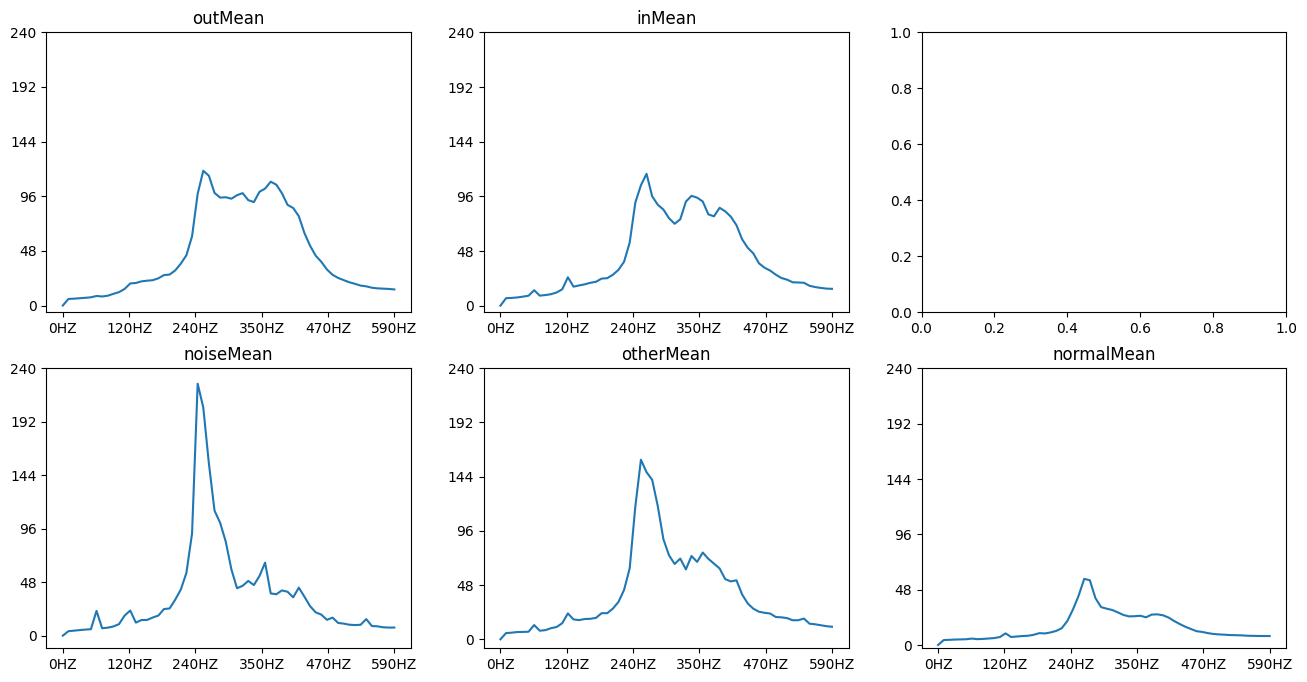

In [92]:
train = df_t[cols].copy()
train = train.drop(train.loc[:, '600HZ':].columns, axis=1).copy()

hzCols = [col for col in train.columns if 'HZ' in col]
outMean = makeMean(hzCols,'out')
inMean = makeMean(hzCols,'in')
noiseMean = makeMean(hzCols,'noise')
otherMean = makeMean(hzCols,'other')
normalMean = makeMean(hzCols,'normal')

xSize = len(outMean) - 1 
ySize = 240

fig, ax = plt.subplots(2, 3, figsize=(16, 8))


printPlt(0,0,outMean,'outMean',xSize, ySize)
printPlt(0,1,inMean,'inMean',xSize, ySize)
printPlt(1,0,noiseMean,'noiseMean',xSize, ySize)
printPlt(1,1,otherMean,'otherMean',xSize, ySize)
printPlt(1,2,normalMean,'normalMean',xSize, ySize)

plt.show()

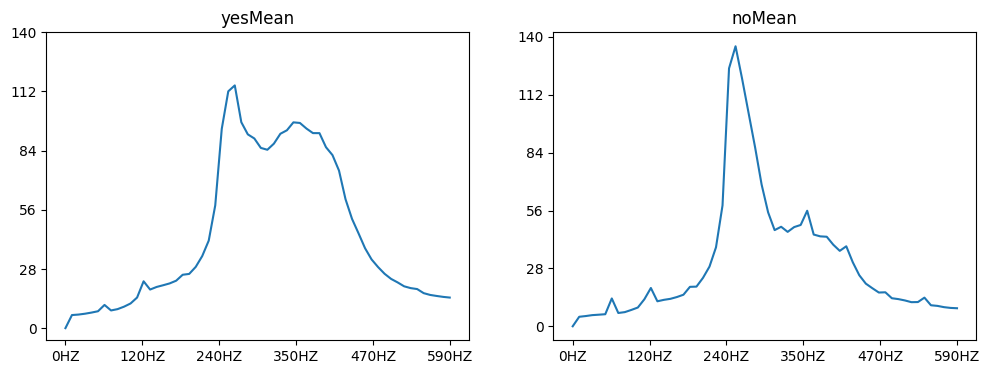

In [93]:
#누수 O hz 평균 그래프
yesMean = (outMean + inMean) / 2
noMean = (noiseMean + otherMean + normalMean) / 3

fig, ax = plt.subplots(1,2, figsize=(12, 4))
xSize = len(yesMean) - 1 
ySize2 = 140

printPlt2(0,yesMean,'yesMean',xSize, ySize2)
printPlt2(1,noMean,'noMean',xSize, ySize2)

plt.show()

<AxesSubplot: title={'center': 'yesMean - noMean'}>

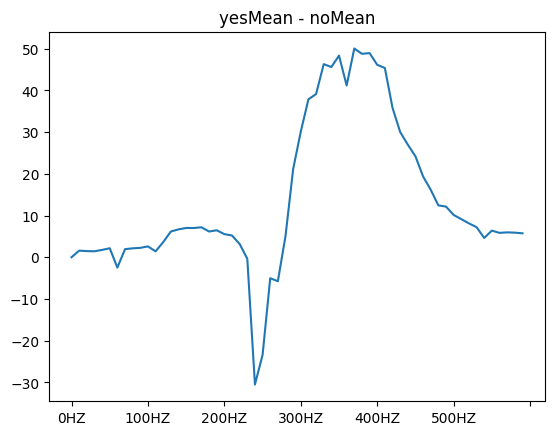

In [94]:
gapMean = yesMean - noMean
plt.title('yesMean - noMean')
gapMean.plot()

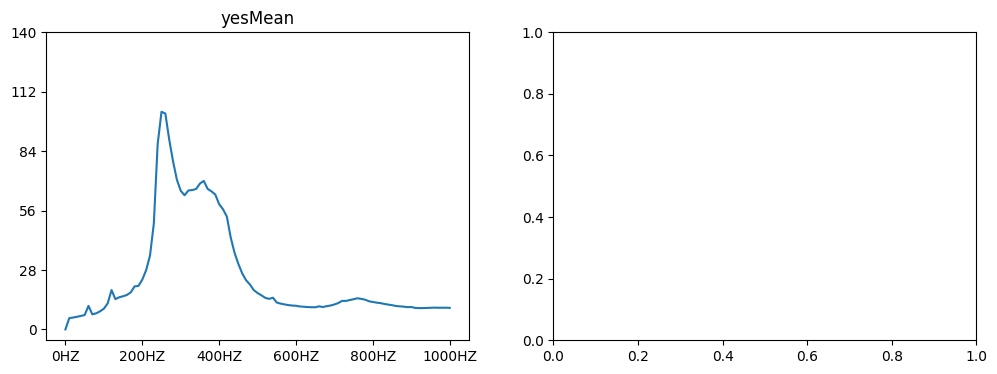

In [80]:
train = df_t[cols].copy()
train = train.drop(train.loc[:, '1010HZ':].columns, axis=1).copy()
#누수 O hz 평균 그래프

#누수 O hz 평균 그래프
train = train.mean()

fig, ax = plt.subplots(1,2, figsize=(12, 4))
xSize = len(yesMean) - 1 
ySize2 = 140

printPlt2(0,yesMean,'yesMean',xSize, ySize2)

plt.show()

In [ ]:
# 기준모델
# minMaxScale    : 미적용
# OrdinalEncoder : 적용
# Hz             : 미제한
# LabelEncoder,  
# XGBClassifier

import warnings
warnings.filterwarnings('ignore')

start = time.time()  # 시작 시간 저장

train = df_t[cols].copy()
val = df_v[cols].copy()

# feature/target 분리
train, test = train_test_split(train, test_size=0.2, stratify=train[target], random_state=42)
X_train, y_train = train.drop(columns=[target]), train[target]
X_test, y_test = test.drop(columns=[target]), test[target]
X_val, y_val = val.drop(columns=[target]), val[target]

encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)
X_val_encoded = encoder.transform(X_val)

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

model = XGBClassifier(
    objective="multi:softprob",
    eval_metric="auc",
    n_estimators=99999,
    random_state=42,
)

watchlist = [(X_train_encoded, y_train), (X_test_encoded, y_test)]

model.fit(
    X_train_encoded,
    y_train,
    eval_set=watchlist,
    early_stopping_rounds=50, # 50 rounds 동안 성능 개선이 없으면 학습을 중지합니다.
)

y_val_pred = model.predict(X_val)
from sklearn.metrics import classification_report

print(classification_report(y_val, y_val_pred))

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간
#               precision    recall  f1-score   support
# objective="multi:softprob",
# eval_metric="auc",
# n_estimators=99999,
# random_state=42,
#               precision    recall  f1-score   support

#            0       0.93      0.93      0.93      1659
#            1       0.91      0.85      0.88       629
#            2       0.96      0.99      0.97      2462
#            3       0.94      0.85      0.89       878
#            4       0.93      0.95      0.94      2192

#     accuracy                           0.94      7820
#    macro avg       0.93      0.91      0.92      7820
# weighted avg       0.94      0.94      0.94      7820

In [ ]:
train = df_t[cols].copy()
val = df_v[cols].copy()

train = train.drop(train.loc[:, '1010HZ':].columns, axis=1).copy()
val = val.drop(val.loc[:, '1010HZ':].columns, axis=1).copy()
train

In [ ]:
###
# minMaxScale    : 미적용
# OrdinalEncoder : 미적용
# Hz             : 제한
# LabelEncoder,  
# XGBClassifier

from scipy.stats.distributions import uniform
from sklearn.model_selection import RandomizedSearchCV


train = df_t[cols].copy()
val = df_v[cols].copy()

train = train.drop(train.loc[:, '1010HZ':].columns, axis=1).copy()
val = val.drop(val.loc[:, '1010HZ':].columns, axis=1).copy()

target = 'leaktype'

train, test = train_test_split(train, test_size=0.2, stratify=train[target], random_state=42)
X_train, y_train = train.drop(columns=[target]), train[target]
X_test, y_test = test.drop(columns=[target]), test[target]
X_val, y_val = val.drop(columns=[target]), val[target]

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)


pipe = make_pipeline(
  OrdinalEncoder(),
  XGBClassifier(n_estimators=1000
                , random_state=2
                , n_jobs=-1
                , objective='multi:softprob'
                )
)

from scipy.stats.distributions import uniform
from sklearn.model_selection import RandomizedSearchCV

params = {
    "xgbclassifier__max_depth": [ 6, 8, 10, 12],
    "xgbclassifier__min_child_weight": [6, 8, 10, 12],
    "xgbclassifier__colsample_bytree": uniform(loc=0.5, scale=0.5),  # 0.5 ~ 1 사이의 uniform 분포로 범위를 지정해 줍니다.

}


randomized_search = RandomizedSearchCV(
    pipe,
    param_distributions=params,
    n_iter=200,
    cv=3,
    verbose=3,
    random_state=42,
    scoring = 'roc_auc'
)

randomized_search.fit(X_train, y_train)

print("최적 하이퍼파라미터: ", randomized_search.best_params_)
print("최적 f1: ", randomized_search.best_score_)
# 최적 하이퍼파라미터:  {
#     'xgbclassifier__colsample_bytree': 0.6872700594236812, 
#     'xgbclassifier__learning_rate': 0.05, 
# 'xgbclassifier__max_depth': 6, 
# 'xgbclassifier__min_child_weight': 8}
# 최적 f1:  nan

In [188]:
# minMaxScale    : 미적용
# OrdinalEncoder : 적용
# Hz             : 미제한
# LabelEncoder,  
# XGBClassifier

import warnings
warnings.filterwarnings('ignore')

hzCols1 = [col for col in df_v.columns if 'HZ' in col]
cols = ['leaktype']
cols += hzCols1

train = df_t[cols].copy()
val = df_v[cols].copy()

train = train.drop(train.loc[:, '1010HZ':].columns, axis=1).copy()
val = val.drop(val.loc[:, '1010HZ':].columns, axis=1).copy()

target = 'leaktype'

train, test = train_test_split(train, test_size=0.2, stratify=train[target], random_state=42)
X_train, y_train = train.drop(columns=[target]), train[target]
X_test, y_test = test.drop(columns=[target]), test[target]
X_val, y_val = val.drop(columns=[target]), val[target]

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

model = XGBClassifier(
    objective="multi:softprob",
    eval_metric="aucpr",
    n_estimators=99999,
    random_state=42,
    max_depth = 12,
    learning_rate=0.1,
    reg_alpha = 0.1
    colsample_bytree=0.9
)

watchlist = [(X_train, y_train), (X_test, y_test)]

model.fit(
    X_train,
    y_train,
    eval_set=watchlist,
    early_stopping_rounds=200, 
)

y_val_pred = model.predict(X_val)
from sklearn.metrics import classification_report

print(classification_report(y_val, y_val_pred))
#               precision    recall  f1-score   support
# objective="multi:softprob",
# eval_metric="auc",
# n_estimators=99999,
# random_state=42,
# [2069]	validation_0-auc:1.00000	validation_1-auc:0.99368
#               precision    recall  f1-score   support

#            0       0.92      0.92      0.92      1659
#            1       0.91      0.87      0.89       629
#            2       0.95      0.98      0.97      2462
#            3       0.93      0.84      0.89       878
#            4       0.93      0.95      0.94      2192

#     accuracy                           0.94      7820
#    macro avg       0.93      0.91      0.92      7820
# weighted avg       0.93      0.94      0.93      7820+



[0]	validation_0-aucpr:0.85350	validation_1-aucpr:0.74363
[1]	validation_0-aucpr:0.89838	validation_1-aucpr:0.79973
[2]	validation_0-aucpr:0.91351	validation_1-aucpr:0.81931
[3]	validation_0-aucpr:0.92516	validation_1-aucpr:0.83468
[4]	validation_0-aucpr:0.93202	validation_1-aucpr:0.84513
[5]	validation_0-aucpr:0.93828	validation_1-aucpr:0.85388
[6]	validation_0-aucpr:0.94335	validation_1-aucpr:0.86103
[7]	validation_0-aucpr:0.94801	validation_1-aucpr:0.86744
[8]	validation_0-aucpr:0.95250	validation_1-aucpr:0.87352
[9]	validation_0-aucpr:0.95654	validation_1-aucpr:0.87993
[10]	validation_0-aucpr:0.96167	validation_1-aucpr:0.88596
[11]	validation_0-aucpr:0.96653	validation_1-aucpr:0.89174
[12]	validation_0-aucpr:0.97012	validation_1-aucpr:0.89655
[13]	validation_0-aucpr:0.97306	validation_1-aucpr:0.90099
[14]	validation_0-aucpr:0.97529	validation_1-aucpr:0.90497
[15]	validation_0-aucpr:0.97716	validation_1-aucpr:0.90781
[16]	validation_0-aucpr:0.97926	validation_1-aucpr:0.91116
[17]	va

              precision    recall  f1-score   support

           0       0.93      0.92      0.92      1659
           1       0.92      0.86      0.89       629
           2       0.95      0.98      0.97      2462
           3       0.93      0.86      0.89       878
           4       0.93      0.95      0.94      2192

    accuracy                           0.94      7820
   macro avg       0.93      0.91      0.92      7820
weighted avg       0.94      0.94      0.94      7820



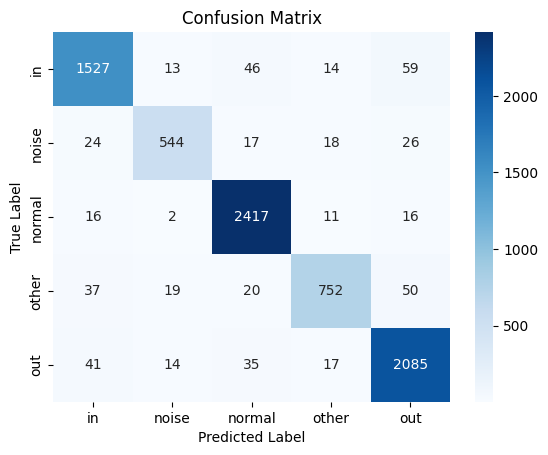

In [189]:
print(classification_report(y_val, y_val_pred))

draw_confusion_matrix(y_val, y_val_pred, le.classes_)


In [ ]:
# minMaxScale    : 미적용
# OrdinalEncoder : 적용
# Hz             : 제한
# LabelEncoder,  
# XGBClassifier

import warnings
warnings.filterwarnings('ignore')

# Make DataFrame
#필요 컬럼 : 
      # index : sid 
      # X : , (X)HZ
      # y : leaktype

train = df_t[cols].copy()
val = df_v[cols].copy()

# train.dropna(inplace = True)
# train.drop_duplicates(inplace = True)

# val.dropna(inplace = True)
# val.drop_duplicates(inplace = True)

train = train.drop(train.loc[:, '1010HZ':].columns, axis=1).copy()
val = val.drop(val.loc[:, '1010HZ':].columns, axis=1).copy()

target = 'leaktype'

train, test = train_test_split(train, test_size=0.2, stratify=train[target], random_state=42)
X_train, y_train = train.drop(columns=[target]), train[target]
X_test, y_test = test.drop(columns=[target]), test[target]
X_val, y_val = val.drop(columns=[target]), val[target]

# MinMaxScaler
# X_train = minMaxScale(X_train)
# X_test = minMaxScale(X_test)
# X_val = minMaxScale(X_val)

encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)
X_val_encoded = encoder.transform(X_val)

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

model = XGBClassifier(
    objective="multi:softprob",
    eval_metric="auc",
    n_estimators=99999,
    random_state=42,
)

watchlist = [(X_train_encoded, y_train), (X_test_encoded, y_test)]

model.fit(
    X_train_encoded,
    y_train,
    eval_set=watchlist,
    early_stopping_rounds=200, # 50 rounds 동안 성능 개선이 없으면 학습을 중지합니다.
)

y_val_pred = model.predict(X_val_encoded)
print(classification_report(y_val, y_val_pred))

draw_confusion_matrix(y_val, y_val_pred, le.classes_)

#               precision    recall  f1-score   support
# objective="multi:softprob",
# eval_metric="auc",
# n_estimators=99999,
# random_state=42,
# [2070]	validation_0-auc:1.00000	validation_1-auc:0.99368
#               precision    recall  f1-score   support

#            0       0.92      0.92      0.92      1659
#            1       0.91      0.87      0.89       629
#            2       0.95      0.98      0.97      2462
#            3       0.93      0.84      0.89       878
#            4       0.93      0.95      0.94      2192

#     accuracy                           0.94      7820
#    macro avg       0.93      0.91      0.92      7820
# weighted avg       0.93      0.94      0.93      7820

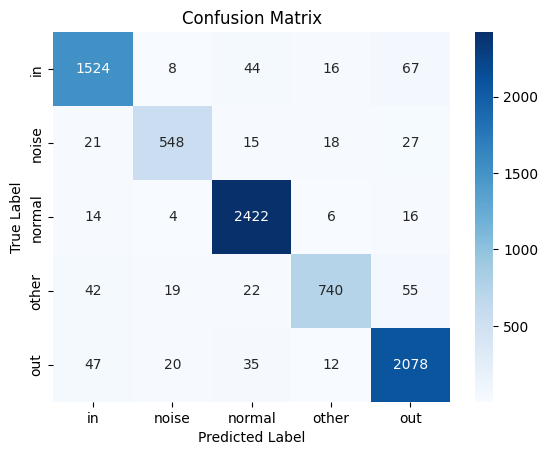

In [65]:
draw_confusion_matrix(y_val, y_val_pred, le.classes_)

In [ ]:
# minMaxScale    : 미적용
# OrdinalEncoder : 적용
# Hz             : 제한
# LabelEncoder,  
# XGBClassifier

import warnings
warnings.filterwarnings('ignore')

train = df_t[cols].copy()
val = df_v[cols].copy()
train = train.drop(train.loc[:, '1010HZ':].columns, axis=1).copy()
val = val.drop(val.loc[:, '1010HZ':].columns, axis=1).copy()

target = 'leaktype'

train, test = train_test_split(train, test_size=0.2, stratify=train[target], random_state=42)
X_train, y_train = train.drop(columns=[target]), train[target]
X_test, y_test = test.drop(columns=[target]), test[target]
X_val, y_val = val.drop(columns=[target]), val[target]

# MinMaxScaler
# X_train = minMaxScale(X_train)
# X_test = minMaxScale(X_test)
# X_val = minMaxScale(X_val)

encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)
X_val_encoded = encoder.transform(X_val)

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

model = XGBClassifier(
    objective="multi:softprob",
    eval_metric="auc",
    n_estimators=99999,
    random_state=42,
)

watchlist = [(X_train_encoded, y_train), (X_test_encoded, y_test)]

model.fit(
    X_train_encoded,
    y_train,
    eval_set=watchlist,
    early_stopping_rounds=200, # 50 rounds 동안 성능 개선이 없으면 학습을 중지합니다.
)

y_val_pred = model.predict(X_val_encoded)
print(classification_report(y_val, y_val_pred))

draw_confusion_matrix(y_val, y_val_pred, le.classes_)


[0]	validation_0-auc:0.85439	validation_1-auc:0.80758
[1]	validation_0-auc:0.87621	validation_1-auc:0.83502
[2]	validation_0-auc:0.88934	validation_1-auc:0.85104
[3]	validation_0-auc:0.90082	validation_1-auc:0.86116
[4]	validation_0-auc:0.90853	validation_1-auc:0.87022
[5]	validation_0-auc:0.91634	validation_1-auc:0.87743
[6]	validation_0-auc:0.92167	validation_1-auc:0.88183
[7]	validation_0-auc:0.92787	validation_1-auc:0.88703
[8]	validation_0-auc:0.93212	validation_1-auc:0.89088
[9]	validation_0-auc:0.93574	validation_1-auc:0.89484
[10]	validation_0-auc:0.93990	validation_1-auc:0.89837
[11]	validation_0-auc:0.94379	validation_1-auc:0.90199
[12]	validation_0-auc:0.94701	validation_1-auc:0.90544
[13]	validation_0-auc:0.94940	validation_1-auc:0.90768
[14]	validation_0-auc:0.95151	validation_1-auc:0.91019
[15]	validation_0-auc:0.95339	validation_1-auc:0.91180
[16]	validation_0-auc:0.95501	validation_1-auc:0.91372
[17]	validation_0-auc:0.95725	validation_1-auc:0.91567
[18]	validation_0-au

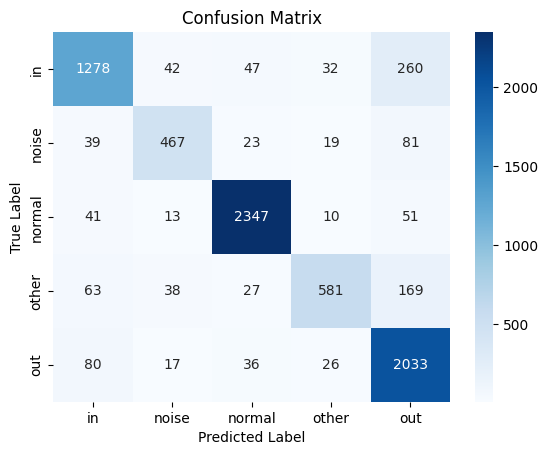

In [170]:
# minMaxScale    : 적용
# OrdinalEncoder : 미적용
# Hz             : 제한
# LabelEncoder,  
# XGBClassifier

import warnings
warnings.filterwarnings('ignore')

train = df_t[cols].copy()
val = df_v[cols].copy()
train = train.drop(train.loc[:, '1010HZ':].columns, axis=1).copy()
val = val.drop(val.loc[:, '1010HZ':].columns, axis=1).copy()

target = 'leaktype'

train, test = train_test_split(train, test_size=0.2, stratify=train[target], random_state=42)
X_train, y_train = train.drop(columns=[target]), train[target]
X_test, y_test = test.drop(columns=[target]), test[target]
X_val, y_val = val.drop(columns=[target]), val[target]

MinMaxScaler
X_train = minMaxScale(X_train)
X_test = minMaxScale(X_test)
X_val = minMaxScale(X_val)

# encoder = OrdinalEncoder()
# X_train_encoded = encoder.fit_transform(X_train)
# X_test_encoded = encoder.transform(X_test)
# X_val_encoded = encoder.transform(X_val)

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

model = XGBClassifier(
    objective="multi:softprob",
    eval_metric="auc",
    n_estimators=99999,
    random_state=42,
)

watchlist = [(X_train, y_train), (X_test, y_test)]

model.fit(
    X_train,
    y_train,
    eval_set=watchlist,
    early_stopping_rounds=200, # 50 rounds 동안 성능 개선이 없으면 학습을 중지합니다.
)

y_val_pred = model.predict(X_val)
print(classification_report(y_val, y_val_pred))

draw_confusion_matrix(y_val, y_val_pred, le.classes_)


[0]	validation_0-auc:0.85439	validation_1-auc:0.84545
[1]	validation_0-auc:0.87621	validation_1-auc:0.86611
[2]	validation_0-auc:0.88934	validation_1-auc:0.87831
[3]	validation_0-auc:0.90082	validation_1-auc:0.88919
[4]	validation_0-auc:0.90853	validation_1-auc:0.89688
[5]	validation_0-auc:0.91634	validation_1-auc:0.90313
[6]	validation_0-auc:0.92167	validation_1-auc:0.90728
[7]	validation_0-auc:0.92787	validation_1-auc:0.91273
[8]	validation_0-auc:0.93212	validation_1-auc:0.91650
[9]	validation_0-auc:0.93574	validation_1-auc:0.91960
[10]	validation_0-auc:0.93990	validation_1-auc:0.92346
[11]	validation_0-auc:0.94379	validation_1-auc:0.92676
[12]	validation_0-auc:0.94701	validation_1-auc:0.92975
[13]	validation_0-auc:0.94940	validation_1-auc:0.93211
[14]	validation_0-auc:0.95151	validation_1-auc:0.93440
[15]	validation_0-auc:0.95339	validation_1-auc:0.93599
[16]	validation_0-auc:0.95501	validation_1-auc:0.93766
[17]	validation_0-auc:0.95725	validation_1-auc:0.93971
[18]	validation_0-au

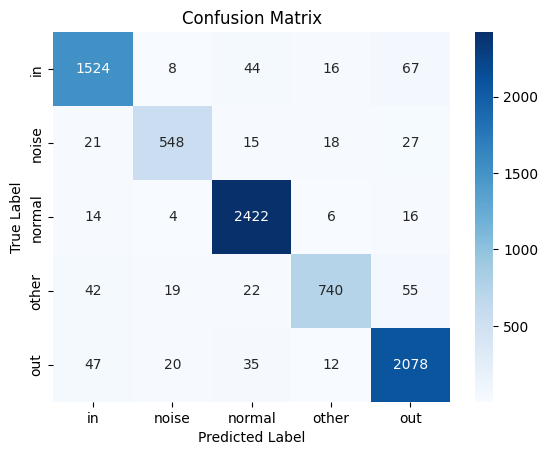

In [99]:
# 01
# minMaxScale    : 미적용
# OrdinalEncoder : 적용
# Hz             : 제한
# LabelEncoder,  
# XGBClassifier
# 개선

import warnings
warnings.filterwarnings('ignore')

train = df_t[cols].copy()
val = df_v[cols].copy()

train = train.drop(train.loc[:, '1010HZ':].columns, axis=1).copy()
val = val.drop(val.loc[:, '1010HZ':].columns, axis=1).copy()

target = 'leaktype'

train, test = train_test_split(train, test_size=0.2, stratify=train[target], random_state=42)
X_train, y_train = train.drop(columns=[target]), train[target]
X_test, y_test = test.drop(columns=[target]), test[target]
X_val, y_val = val.drop(columns=[target]), val[target]

encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)
X_val_encoded = encoder.transform(X_val)

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

model = XGBClassifier(
    objective="multi:softprob",
    eval_metric="auc",
    n_estimators=99999,
    random_state=42,
)

watchlist = [(X_train_encoded, y_train), (X_test_encoded, y_test)]

model.fit(
    X_train_encoded,
    y_train,
    eval_set=watchlist,
    early_stopping_rounds=200, # 50 rounds 동안 성능 개선이 없으면 학습을 중지합니다.
)

y_val_pred = model.predict(X_val_encoded)

print(classification_report(y_val, y_val_pred))

draw_confusion_matrix(y_val, y_val_pred, le.classes_)

plot_importance(model,max_num_features=20,importance_type = "weight")
plt.show()
#               precision    recall  f1-score   support
# objective="multi:softprob",
# eval_metric="auc",
# n_estimators=99999,
# random_state=42,
# [2070]	validation_0-auc:1.00000	validation_1-auc:0.99368
#               precision    recall  f1-score   support

#            0       0.92      0.92      0.92      1659
#            1       0.91      0.87      0.89       629
#            2       0.95      0.98      0.97      2462
#            3       0.93      0.84      0.89       878
#            4       0.93      0.95      0.94      2192

#     accuracy                           0.94      7820
#    macro avg       0.93      0.91      0.92      7820
# weighted avg       0.93      0.94      0.93      7820

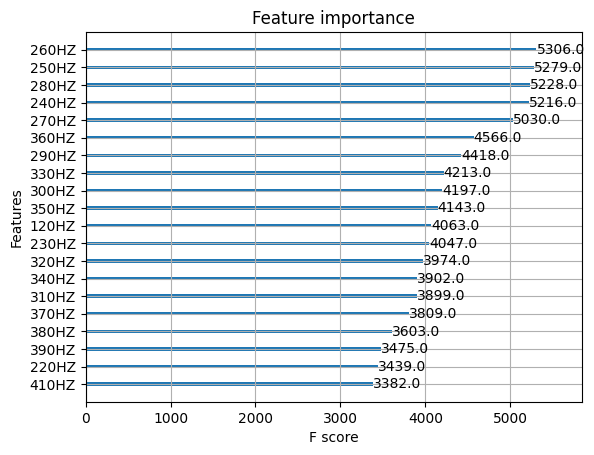

In [100]:
plot_importance(model,max_num_features=20,importance_type = "weight")
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from bayes_opt import BayesianOptimization, UtilityFunction
import xgboost as xgb
from sklearn.metrics import log_loss

#테스트용
# train = df_t[cols].groupby(target).sample(10, random_state=1).copy()
# val = df_v[cols].groupby(target).sample(10, random_state=1).copy()
train = df_t[cols].copy()
val = df_v[cols].copy()

train = train.drop(train.loc[:, '1010HZ':].columns, axis=1).copy()
val = val.drop(val.loc[:, '1010HZ':].columns, axis=1).copy()

# feature/target 분리
train, test = train_test_split(train, test_size=0.2, stratify=train[target], random_state=42)
X_train, y_train = train.drop(columns=[target]), train[target]
X_test, y_test = test.drop(columns=[target]), test[target]
X_val, y_val = val.drop(columns=[target]), val[target]

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)
 

dtest = xgb.DMatrix(data=X_test, label=y_test)
dtrain = xgb.DMatrix(data=X_train, label=y_train)

def xgb_evaluate(max_depth, colsample_bytree, alpha, lambda_):
    params = {
        'eval_metric': 'mlogloss',
        'objective': 'multi:softprob',
        'num_class': 5,
        'booster': 'gbtree',
        'tree_method': 'auto',
        'max_depth': int(max_depth),
        'gamma': 0,
        'min_child_weight': 1,
        'colsample_bytree': colsample_bytree,
        'alpha': alpha,
        'lambda': lambda_
    }

    watchlist = [(dtrain, "train"), (dtest, "test")]
    model = xgb.cv(params, dtrain, num_boost_round=10000, nfold=3, early_stopping_rounds=50)
    
    return min(model['test-mlogloss-mean'])
 
xgb_bo = BayesianOptimization(xgb_evaluate, {'max_depth': (6, 14), 
                                             'colsample_bytree': (0.8, 1),
                                             'lambda_' : (1,1),
                                             'alpha' : (1,1)
                                             }, random_state=0)
 
xgb_bo.maximize(init_points=3, n_iter=20, acq='ei')

print("Best result: {}; f(x) = {}.".format(xgb_bo.max["params"], xgb_bo.max["target"]))

In [ ]:
# def xgb_evaluate(max_depth, gamma, colsample_bytree,min_child_weight,eta,subsample):
#     params = {'eval_metric': 'rmse',
#               'objective':'reg:squarederror',
#               'min_child_weight': min_child_weight,
#               'max_depth': int(max_depth),
#               'subsample': subsample,
#               'eta': eta,
#               'gamma': gamma,
#               'colsample_bytree': colsample_bytree}
# xgb_bo = BayesianOptimization(xgb_evaluate, {'max_depth': (8, 12), 
#                                              'gamma': (0, 1),
#                                              'colsample_bytree': (0.3, 0.9),
#                                             'min_child_weight': (5, 9),
#                                             'eta':(0.1, 0.3),
#                                             'subsample':(0.7, 1.0)}, random_state=0)
 
#     cv_result = xgb.cv(params, dtrain, nfold=3, num_boost_round=1500, early_stopping_rounds=50, )    
# Best result: {'colsample_bytree': 0.6569339752622091, 'eta': 0.1, 'gamma': 0.0, 'max_depth': 8.169205693470644, 'min_child_weight': 8.00210040323896, 'subsample': 1.0}; f(x) = -0.8614478753690392.

[0]	validation_0-auc:0.85733	validation_1-auc:0.80844
[1]	validation_0-auc:0.88202	validation_1-auc:0.83569
[2]	validation_0-auc:0.89542	validation_1-auc:0.85069
[3]	validation_0-auc:0.90595	validation_1-auc:0.86244
[4]	validation_0-auc:0.91393	validation_1-auc:0.86854
[5]	validation_0-auc:0.92155	validation_1-auc:0.87253
[6]	validation_0-auc:0.92891	validation_1-auc:0.87946
[7]	validation_0-auc:0.93360	validation_1-auc:0.88588
[8]	validation_0-auc:0.93791	validation_1-auc:0.88858
[9]	validation_0-auc:0.94189	validation_1-auc:0.89388
[10]	validation_0-auc:0.94558	validation_1-auc:0.89720
[11]	validation_0-auc:0.94917	validation_1-auc:0.90067
[12]	validation_0-auc:0.95223	validation_1-auc:0.90369
[13]	validation_0-auc:0.95467	validation_1-auc:0.90608
[14]	validation_0-auc:0.95638	validation_1-auc:0.90761
[15]	validation_0-auc:0.95873	validation_1-auc:0.91051
[16]	validation_0-auc:0.96026	validation_1-auc:0.91330
[17]	validation_0-auc:0.96173	validation_1-auc:0.91499
[18]	validation_0-au

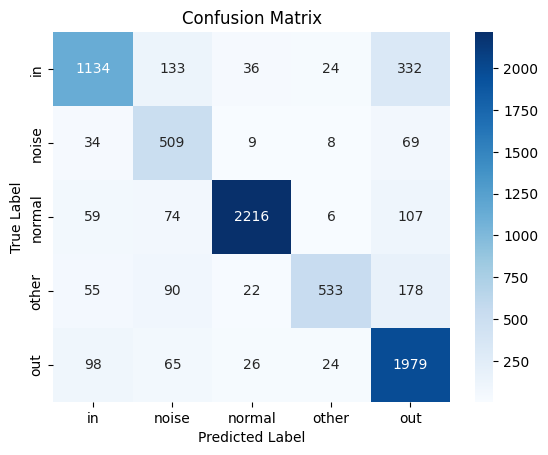

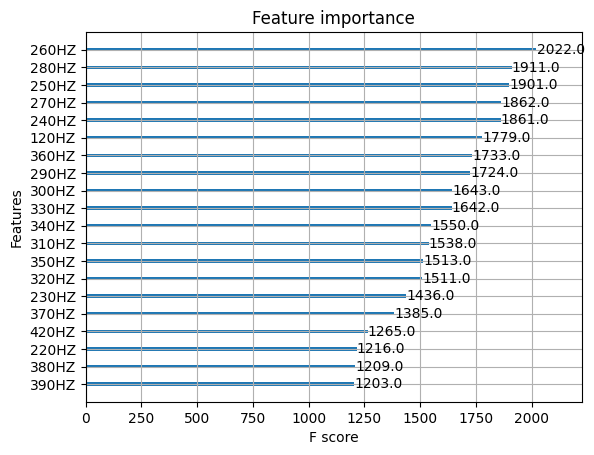

time : 510.8628523349762


In [98]:
# 기준모델
# minMaxScale    : 적용
# OrdinalEncoder : 미적용
# Hz             : 미제한
# LabelEncoder,  
# XGBClassifier
# early_stopping_rounds : 50

import warnings
warnings.filterwarnings('ignore')

start = time.time()  # 시작 시간 저장

train = df_t[cols].copy()
val = df_v[cols].copy()

# feature/target 분리
train, test = train_test_split(train, test_size=0.2, stratify=train[target], random_state=42)
X_train, y_train = train.drop(columns=[target]), train[target]
X_test, y_test = test.drop(columns=[target]), test[target]
X_val, y_val = val.drop(columns=[target]), val[target]

X_train = minMaxScale(X_train)
X_test = minMaxScale(X_test)
X_val = minMaxScale(X_val)

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

model = XGBClassifier(
    objective="multi:softprob",
    eval_metric="auc",
    n_estimators=99999,
    random_state=42,
)

watchlist = [(X_train, y_train), (X_test, y_test)]

model.fit(
    X_train,
    y_train,
    eval_set=watchlist,
    early_stopping_rounds=50, # 50 rounds 동안 성능 개선이 없으면 학습을 중지합니다.
)

y_val_pred = model.predict(X_val)
from sklearn.metrics import classification_report

print(classification_report(y_val, y_val_pred))

draw_confusion_matrix(y_val, y_val_pred, le.classes_)

plot_importance(model,max_num_features=20,importance_type = "weight")
plt.show()

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간
#               precision    recall  f1-score   support
# objective="multi:softprob",
# eval_metric="auc",
# n_estimators=99999,
# random_state=42,
#               precision    recall  f1-score   support

#            0       0.93      0.93      0.93      1659
#            1       0.91      0.85      0.88       629
#            2       0.96      0.99      0.97      2462
#            3       0.94      0.85      0.89       878
#            4       0.93      0.95      0.94      2192

#     accuracy                           0.94      7820
#    macro avg       0.93      0.91      0.92      7820
# weighted avg       0.94      0.94      0.94      7820

[0]	validation_0-auc:0.85439	validation_1-auc:0.80758
[1]	validation_0-auc:0.87621	validation_1-auc:0.83502
[2]	validation_0-auc:0.88934	validation_1-auc:0.85104
[3]	validation_0-auc:0.90082	validation_1-auc:0.86116
[4]	validation_0-auc:0.90853	validation_1-auc:0.87022
[5]	validation_0-auc:0.91634	validation_1-auc:0.87743
[6]	validation_0-auc:0.92167	validation_1-auc:0.88183
[7]	validation_0-auc:0.92787	validation_1-auc:0.88703
[8]	validation_0-auc:0.93212	validation_1-auc:0.89088
[9]	validation_0-auc:0.93574	validation_1-auc:0.89484
[10]	validation_0-auc:0.93990	validation_1-auc:0.89837
[11]	validation_0-auc:0.94379	validation_1-auc:0.90199
[12]	validation_0-auc:0.94701	validation_1-auc:0.90544
[13]	validation_0-auc:0.94940	validation_1-auc:0.90768
[14]	validation_0-auc:0.95151	validation_1-auc:0.91019
[15]	validation_0-auc:0.95339	validation_1-auc:0.91180
[16]	validation_0-auc:0.95501	validation_1-auc:0.91372
[17]	validation_0-auc:0.95725	validation_1-auc:0.91567
[18]	validation_0-au

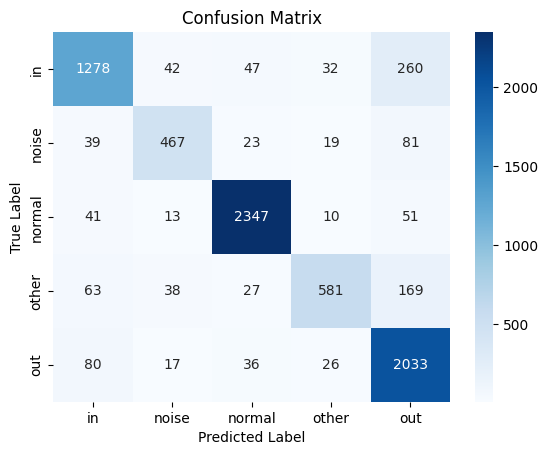

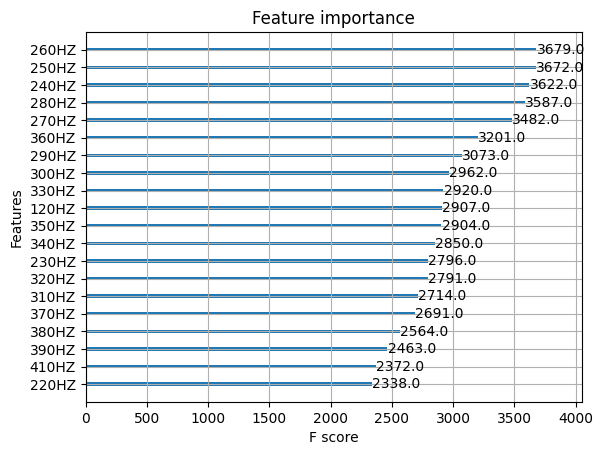

time : 205.08469367027283


In [101]:
# 주요컬럼 모델
# minMaxScale    : 적용
# OrdinalEncoder : 미적용
# Hz             : 미제한
# LabelEncoder,  
# XGBClassifier
# early_stopping_rounds : 50

import warnings
warnings.filterwarnings('ignore')

start = time.time()  # 시작 시간 저장

train = df_t[cols].copy()
val = df_v[cols].copy()

train = train.drop(train.loc[:, '1010HZ':].columns, axis=1).copy()
val = val.drop(val.loc[:, '1010HZ':].columns, axis=1).copy()

# feature/target 분리
train, test = train_test_split(train, test_size=0.2, stratify=train[target], random_state=42)
X_train, y_train = train.drop(columns=[target]), train[target]
X_test, y_test = test.drop(columns=[target]), test[target]
X_val, y_val = val.drop(columns=[target]), val[target]

X_train = minMaxScale(X_train)
X_test = minMaxScale(X_test)
X_val = minMaxScale(X_val)

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

model = XGBClassifier(
    objective="multi:softprob",
    eval_metric="auc",
    n_estimators=99999,
    random_state=42,
)

watchlist = [(X_train, y_train), (X_test, y_test)]

model.fit(
    X_train,
    y_train,
    eval_set=watchlist,
    early_stopping_rounds=50, # 50 rounds 동안 성능 개선이 없으면 학습을 중지합니다.
)

y_val_pred = model.predict(X_val)
from sklearn.metrics import classification_report

print(classification_report(y_val, y_val_pred))

draw_confusion_matrix(y_val, y_val_pred, le.classes_)

plot_importance(model,max_num_features=20,importance_type = "weight")
plt.show()

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

In [ ]:
# 하이퍼 파라메터 수정
# minMaxScale    : 미적용
# OrdinalEncoder : 적용
# Hz             : 제한
# LabelEncoder,  
# XGBClassifier
# early_stopping_rounds : 200

#데이터 호출
train = df_t[cols].copy()
val = df_v[cols].copy()

#HZ 제한
train = train.drop(train.loc[:, '1010HZ':].columns, axis=1).copy()
val = val.drop(val.loc[:, '1010HZ':].columns, axis=1).copy()


# feature/target 분리
train, test = train_test_split(train, test_size=0.2, stratify=train[target], random_state=42)
X_train, y_train = train.drop(columns=[target]), train[target]
X_test, y_test = test.drop(columns=[target]), test[target]
X_val, y_val = val.drop(columns=[target]), val[target]

#LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

#make_pipeline
pipe = make_pipeline(
    OrdinalEncoder(),
    XGBClassifier(
        objective="multi:softprob",
        n_estimators=99999,
        random_state=42,
        n_jobs=-1
    )
)

#params
params = {
    "xgbclassifier__max_depth": [6, 8, 10],
    # "xgbclassifier__colsample_bytree": uniform(
    #      loc=0.5, scale=0.5
    # ),  # 0.5 ~ 1 사이의 uniform 분포로 범위를 지정해 줍니다.
    # "xgbclassifier__learning_rate" : [0.05, 0.1, 0.3]
}

watchlist = [(X_train_encoded, y_train), (X_test_encoded, y_test)]

randomized_search = RandomizedSearchCV(
    pipe,
    param_distributions=params,
    n_iter=5,
    cv=2,
    verbose=3,
    random_state=42,
)

randomized_search.fit(
    X_train_encoded, y_train,
    eval_set=watchlist,
    )

y_test_pred = randomized_search.predict(X_test)



In [ ]:
y_val_pred = model.predict(X_val)
print(classification_report(y_val, y_val_pred))

draw_confusion_matrix(y_val, y_val_pred, le.classes_)

plot_importance(model,max_num_features=20,importance_type = "weight")
plt.show()

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from scipy.stats.distributions import uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import *
from sklearn.metrics import confusion_matrix # 혼동행렬
from sklearn.metrics import accuracy_score # 정확도
from sklearn.metrics import precision_score # 정밀도
from sklearn.metrics import recall_score # 재현율
from sklearn.metrics import f1_score # f1 스코어
from sklearn.metrics import fbeta_score # f베타 스코어


#데이터 호출
train = df_t[cols].copy()
val = df_v[cols].copy()

#HZ 제한
train = train.drop(train.loc[:, '1010HZ':].columns, axis=1).copy()
val = val.drop(val.loc[:, '1010HZ':].columns, axis=1).copy()


# feature/target 분리
train, test = train_test_split(train, test_size=0.2, stratify=train[target], random_state=42)
X_train, y_train = train.drop(columns=[target]), train[target]
X_test, y_test = test.drop(columns=[target]), test[target]
X_val, y_val = val.drop(columns=[target]), val[target]

#OrdinalEncoder
encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)
X_val_encoded = encoder.transform(X_val)

#LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

pipe = make_pipeline(
    OrdinalEncoder(),
    XGBClassifier(
        objective="multi:softprob",
        eval_metric="auc",
        n_estimators=99999,
        random_state=42,
        n_jobs=-1
    )
)

params = {
    "xgbclassifier__max_depth": [6, 8, 10],
    "xgbclassifier__colsample_bytree": uniform(
         loc=0.5, scale=0.5
    ),  # 0.5 ~ 1 사이의 uniform 분포로 범위를 지정해 줍니다.
    # "xgbclassifier__learning_rate" : [0.05, 0.1, 0.3]
}

watchlist = [(X_train_encoded, y_train), (X_test_encoded, y_test)]

randomized_search = RandomizedSearchCV(
    pipe,
    param_distributions=params,
    scoring="f1",
    n_iter=2,
    cv=2,
    verbose=2,
    random_state=42,
)

randomized_search.fit(
    X_train, y_train,
    
    )

print("최적 하이퍼파라미터: ", randomized_search.best_params_)
print("최적 f1: ", randomized_search.best_score_)

# y_val_pred = randomized_search.predict(X_val)
# print(classification_report(y_val, y_val_pred))

# draw_confusion_matrix(y_val, y_val_pred, le.classes_)

# plot_importance(randomized_search,max_num_features=20,importance_type = "weight")
# plt.show()